In [2]:
import os
import numpy as np
import pandas as pd
import lenstronomy
print(lenstronomy.__path__)
from h0rton.configs import TrainValConfig, TestConfig
from baobab.configs import BaobabConfig
import matplotlib.pyplot as plt
from scipy.stats import norm
import h0rton.tdlmc_utils as tdlmc_utils
import baobab.sim_utils as sim_utils
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Plotting params
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='STIXGeneral', size=20)
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2, titlesize='large', labelsize='large')

['/home/jwp/stage/sl/lenstronomy/lenstronomy']


# Combined H0 estimate

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 8/20/2020

__Last run:__ 8/20/2020

__Goals:__
We plot the results of combining lenses under various binning schemes, including

- all the lenses (no binning)
- doubles vs. quads
- Einstein brightness quartiles

__Before_running:__
1. Train the BNN, e.g.
```bash
python -m h0rton.train h0rton/experiments/v1/train.py
```

2. Get inference results for the trained model and the precision ceiling, e.g.
```bash
python h0rton/infer_h0_mcmc_default.py h0rton/experiments/v1/mcmc_default.json
python h0rton/infer_h0_simple_mc_truth.py h0rton/experiments/v0/simple_mc_default.json
```

3. Summarize the inference results, e.g.
```bash
python h0rton/summarize.py 1 mcmc_default
python h0rton/summarize.py 0 mcmc_default
```

4. Combine the individual lens estimates in the above binning schemes, e.g.
```bash
python h0rton/combine_lenses.py 1 
python h0rton/combine_lenses.py 0
```

# Table of contents
1. [Diagnostic plots](#diagnostic_plots)
2. [Combined H0 plots](#combined_h0_plots)
    1. [Doubles vs. quads](#doubles_quads)
    2. [Exposure times](#exposure_times)
    3. [Gamma retrieval vs. Einstein ring brightness](#gamma)
    4. [Gamma retrieval vs. other metrics](#gamma_other_metrics)

In [3]:
n_test = 200 # number of lenses to visualize
version_id = 3 # ID of the version folder in experiments
prec_version_id = 0 # ID of the version folder corresponding to precision ceiling
true_H0 = 70.0
true_Om0 = 0.3
save_fig = True

version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_id)
test_cfg_path = os.path.join(version_dir, 'mcmc_default.json')
test_cfg = TestConfig.from_file(test_cfg_path)
baobab_cfg = BaobabConfig.from_file(test_cfg.data.test_baobab_cfg_path)
train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)
# Read in truth metadata
metadata = pd.read_csv(os.path.join(baobab_cfg.out_dir, 'metadata.csv'), index_col=None, nrows=n_test)
# Read in summary
summary = pd.read_csv(os.path.join(version_dir, 'summary.csv'), index_col=None, nrows=n_test)

In [4]:
# Drop irrelevant lenses
summary.drop(summary[summary['id']>(n_test - 1)].index, inplace=True)
outside_rung = summary[summary['inference_time'] == 0].index
summary.drop(outside_rung, inplace=True)
print("Number of lenses being combined: {:d}".format(summary.shape[0]))
print("Lenses that were discarded: ", set(np.arange(n_test)) - set(summary['id'].values))

Number of lenses being combined: 200
Lenses that were discarded:  set()


## Diagnostic plots <a name="diagnostic_plots"></a>

In [5]:
w = 1.0/summary['H0_std'].values**2.0 # weight each lens by the inverse H0 variance
weighted_mean = np.average(summary['H0_mean'], weights=w) 
summary['z'] = (summary['H0_mean'] - weighted_mean)/summary['H0_std'] # deviations from weighted mean
summary['z_from_true'] = (summary['H0_mean'] - true_H0)/summary['H0_std'] # deviations from true H0
weighted_std = np.average((summary['H0_mean'].values - weighted_mean)**2, weights=w)**0.5 # deviations from weighted mean and weighted std
summary['z_weighted_std'] = (summary['H0_mean'].values - weighted_mean)/weighted_std
print("weighted mean: ", weighted_mean)
print("weighted std: ", weighted_std)

weighted mean:  69.73261757760146
weighted std:  6.849330735184283


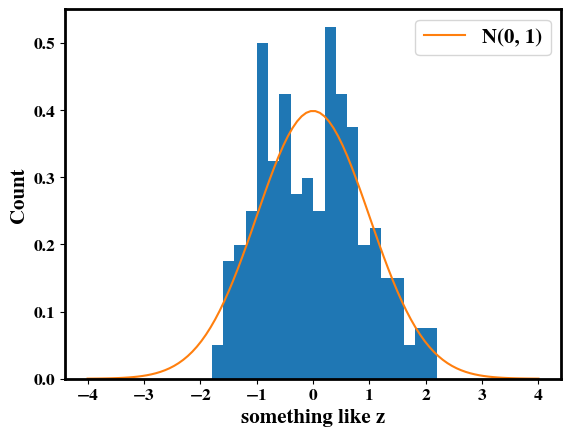

In [6]:
# Plot distribution of H0 z
plt.hist(summary['z_weighted_std'].values, bins=20, density=True)
z_grid = np.linspace(-4, 4, 100)
plt.plot(z_grid, norm.pdf(z_grid, 0, 1), label='N(0, 1)')
plt.ylabel('Count')
plt.xlabel('something like z')
plt.legend()
plt.show()
if save_fig:
    plt.savefig(os.path.join(version_dir, 'something_like_z.png'), bbox_inches='tight', pad_inches=0)

7.223337344328563


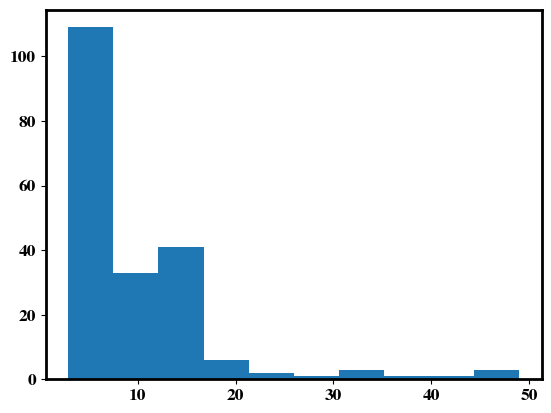

In [7]:
plt.close()
plt.hist(summary['inference_time'].values)
print(np.median(summary['inference_time'].values))
plt.show()

6.596400188478877


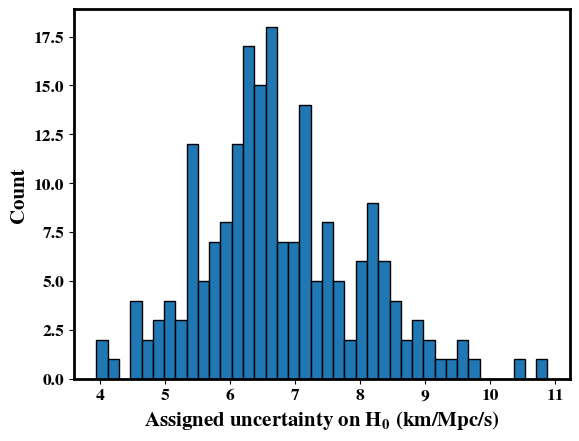

In [8]:
# Plot distribution of H0 std
plt.close()
plt.hist(summary['H0_std'].values, edgecolor='k', bins=40)
print(np.median(summary['H0_std'].values))
plt.ylabel('Count')
plt.xlabel('Assigned uncertainty on $H_0$ (km/Mpc/s)')
plt.show()
if save_fig:
    plt.savefig(os.path.join(version_dir, 'H0_std.png'), bbox_inches='tight', pad_inches=0)

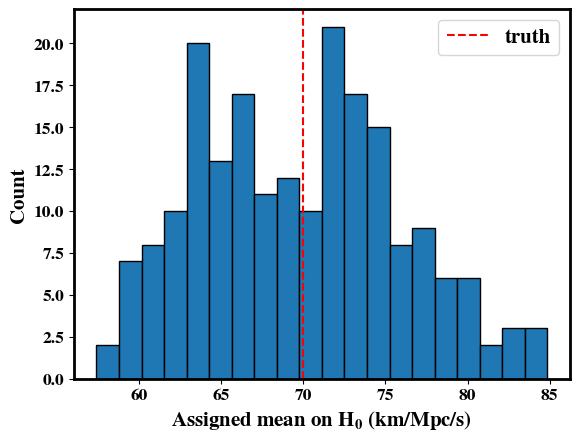

In [9]:
# Plot distribution of H0 mean
plt.close()
plt.hist(summary['H0_mean'].values, edgecolor='k', bins=20)
plt.axvline(true_H0, c='r', linestyle='--', label='truth')
plt.ylabel('Count')
plt.xlabel('Assigned mean on $H_0$ (km/Mpc/s)')
plt.legend()
plt.show()
if save_fig:
    plt.savefig(os.path.join(version_dir, 'H0_mean.png'), bbox_inches='tight', pad_inches=0)

In [10]:
# Compute TDLMC metrics
summary['keep'] = True # keep all lenses #(np.abs(summary['z']) < 3.0)
tdlmc_mean = summary['H0_mean'][summary['keep']]
tdlmc_std = summary['H0_std'][summary['keep']]
summary['g'] = ((summary['H0_mean'] - true_H0)/summary['H0_std'])**2.0
summary['log_g'] = np.log10(summary['g'])
summary['p'] = (summary['H0_std']/true_H0)
summary['a'] = (summary['H0_mean'] - true_H0)/true_H0
G = tdlmc_utils.get_goodness(tdlmc_mean,tdlmc_std, true_H0)
P = tdlmc_utils.get_precision(tdlmc_std, true_H0)
A = tdlmc_utils.get_accuracy(tdlmc_mean, true_H0)
print("Goodness of fit: ", G)
print("Log G: ", np.log10(G))
print("Precision: ", P)
print("Accuracy: ", A)

Goodness of fit:  1.1367848467251727
Log G:  0.055678275838218626
Precision:  0.09654782706946603
Accuracy:  -0.0027262909491800958


In [11]:
# Assign doubles vs quads
summary['is_quad'] = (summary['n_img'] == 4)
print("Doubles: ", len(summary[~summary['is_quad']]))
print("Quads: ", len(summary[summary['is_quad']]))
doubles = summary[~summary['is_quad']].iloc[:n_test]
quads = summary[summary['is_quad']].iloc[:n_test]

Doubles:  111
Quads:  89


In [12]:
prec_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(prec_version_id)
prec_summary = pd.read_csv(os.path.join(prec_version_dir, 'ering_summary.csv'), index_col=None, nrows=n_test)
summary['lensed_E_ring_mag'] = prec_summary['lensed_E_ring_mag'].values

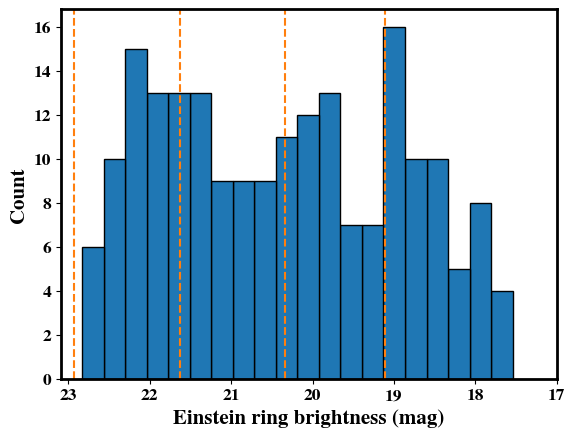

In [13]:
lensed_ring_bins = np.quantile(summary['lensed_E_ring_mag'].values, [0.25, 0.5, 0.75, 1])
lensed_ring_bins[-1] += 0.1 # buffer 
summary['lensed_ring_bin'] = np.digitize(summary['lensed_E_ring_mag'].values, lensed_ring_bins)

plt.close()
plt.hist(summary['lensed_E_ring_mag'], edgecolor='k', bins=20)
plt.xticks(np.arange(17.0, 24.0, step=1.0))
plt.gca().invert_xaxis()
for bin_edge in list(lensed_ring_bins):
    plt.axvline(bin_edge, color='tab:orange', linestyle='--')
plt.xlabel('Einstein ring brightness (mag)')
plt.ylabel('Count')
plt.show()
if save_fig:
    plt.savefig(os.path.join(version_dir, 'ering_bins.png'), bbox_inches='tight', pad_inches=0)

Just to test the binning, let's see if the following values end up in the correct bins. Brightest should be bin 0.

In [14]:
np.digitize(np.array([18, 20, 21, 22]), lensed_ring_bins)

array([0, 1, 2, 3])

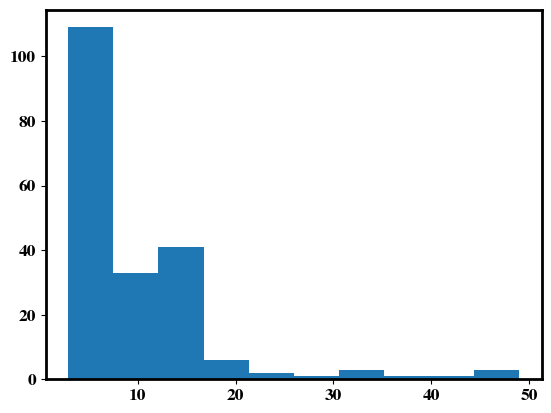

In [15]:
plt.hist(summary['inference_time'])
plt.show()

In [16]:
summary[summary['n_img']==2]['inference_time'].describe()


count    111.000000
mean      12.238980
std        8.593025
min        2.897387
25%        7.061703
50%       10.717003
75%       13.939476
max       49.009878
Name: inference_time, dtype: float64

In [17]:
summary[summary['n_img']==4]['inference_time'].describe()

count    89.000000
mean      7.122214
std       5.686443
min       3.256872
25%       4.261469
50%       6.047280
75%       6.708824
max      47.317016
Name: inference_time, dtype: float64

In [18]:
summary[summary['inference_time']>30]['n_img'].value_counts()

2.0    7
4.0    1
Name: n_img, dtype: int64

## Combined H0 plots <a name="combined_h0_plots"></a>

10000
71.41743278582047 69.6492517390975 0.8456615893155117


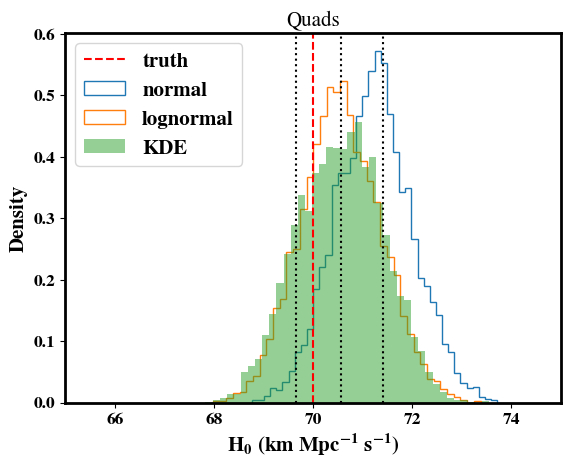

In [19]:
plt.close('all')

h0_samples = np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(2), 'combined_H0_quads_kde.npy'))

plt.hist(np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(2), 'combined_H0_quads.npy')), bins=40,  density=True, label='normal', histtype='step')

plt.hist(np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(2), 'combined_H0_quads_lognormal.npy')), bins=40,  density=True, label='lognormal', histtype='step')
print(len(h0_samples))
#plt.axvline(np.median(h0_samples), color='k')
plus_sig = np.quantile(h0_samples, 0.5+0.341)
minus_sig = np.quantile(h0_samples, 0.5-0.341)
plt.axvline(np.quantile(h0_samples, 0.5), linestyle='dotted', color='k')
plt.axvline(plus_sig, linestyle='dotted', color='k')
plt.axvline(minus_sig, linestyle='dotted', color='k')
print(plus_sig, minus_sig, plus_sig - np.median(h0_samples))

plt.title('Quads')
plt.axvline(70, color='r', linestyle='--', label='truth')
plt.hist(h0_samples, bins=40, alpha=0.5, density=True, label='KDE')
plt.xlim([65, 75])
plt.xlabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)")
plt.ylabel('Density')
plt.legend()
plt.show()

10000
70.6642495108865 68.99566080289742 0.8082489832628852


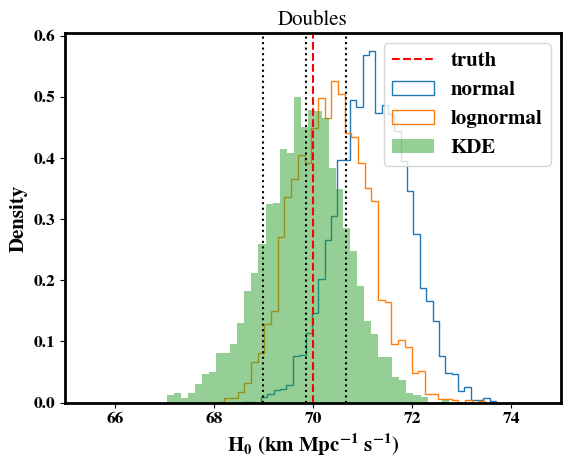

In [20]:
plt.close('all')

h0_samples = np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(2), 'combined_H0_doubles_kde.npy'))

plt.hist(np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(2), 'combined_H0_doubles.npy')), bins=40,  density=True, label='normal', histtype='step')

plt.hist(np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(2), 'combined_H0_doubles_lognormal.npy')), bins=40,  density=True, label='lognormal', histtype='step')
print(len(h0_samples))
#plt.axvline(np.median(h0_samples), color='k')
plus_sig = np.quantile(h0_samples, 0.5+0.341)
minus_sig = np.quantile(h0_samples, 0.5-0.341)
plt.axvline(np.quantile(h0_samples, 0.5), linestyle='dotted', color='k')
plt.axvline(plus_sig, linestyle='dotted', color='k')
plt.axvline(minus_sig, linestyle='dotted', color='k')
print(plus_sig, minus_sig, plus_sig - np.median(h0_samples))

plt.title('Doubles')
plt.axvline(70, color='r', linestyle='--', label='truth')
plt.hist(h0_samples, bins=40, alpha=0.5, density=True, label='KDE')
plt.xlim([65, 75])
plt.xlabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)")
plt.ylabel('Density')
plt.legend()
plt.show()

### Doubles vs. quads <a name="doubles_quads"></a>

In [23]:
# Modify this
orbit_to_ver = dict(zip([0.5, 1, 2, 4], [4, 3, 2]))
#orbit_to_ver = dict(zip([4, 1], [1, 3]))
orbits_available = [0.5, 1, 2]
img_conf_available = ['doubles', 'quads']
prec_version = 0

include_prec_ceiling = True

# This is fixed
orbit_to_color = dict(zip([2, 1, 0.5], ['#843c39', '#d6616b', '#e7969c']))# ['#880519', '#c04546', '#f97978']))
#colors_dict = dict(zip([0.5, 1, 2, 4],  ['#ffbcaf', '#f4777f', '#cf3759', '#93003a']))
orbit_to_seconds = {0.5: '2,700s', 1:'5,400s', 2:'10,800s', 4:'21,600s'}
conf_to_x_pos = {'doubles': 0, 'quads': 1}

h0_samples_lognormal = {} # h0_samples_lognormal[orbit][doubles/quads] = array of D_dt samples
for orbit_i, orbit in enumerate(orbits_available):
    likelihood_type = 'lognormal' #'kde_bandwidth=100'#
    version_i = orbit_to_ver[orbit]
    version_dir_orbit = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_i)
    h0_samples_lognormal[orbit] = {}
    # Add all lenses combined for this orbit
    h0_samples_lognormal[orbit]['all'] =  np.load(os.path.join(version_dir_orbit, 'combined_H0_summary_{:s}.npy'.format(likelihood_type)), allow_pickle=True).squeeze()
    # Add doubles, quads combined for this orbit
    for conf_i, conf in enumerate(img_conf_available):
        h0_samples_lognormal[orbit][conf] = np.load(os.path.join(version_dir_orbit, 'combined_H0_{:s}_{:s}.npy'.format(conf, likelihood_type)), allow_pickle=True).squeeze()
        
h0_samples_normal = {} # h0_samples_lognormal[orbit][doubles/quads] = array of D_dt samples
for orbit_i, orbit in enumerate(orbits_available):
    #likelihood_type = 'normal'
    version_i = orbit_to_ver[orbit]
    version_dir_orbit = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_i)
    h0_samples_normal[orbit] = {}
    # Add all lenses combined for this orbit
    h0_samples_normal[orbit]['all'] =  np.load(os.path.join(version_dir_orbit, 'combined_H0_summary.npy'), allow_pickle=True).squeeze()
    # Add doubles, quads combined for this orbit
    for conf_i, conf in enumerate(img_conf_available):
        h0_samples_normal[orbit][conf] = np.load(os.path.join(version_dir_orbit, 'combined_H0_{:s}.npy'.format(conf)), allow_pickle=True).squeeze()
        
h0_samples_kde = {} # h0_samples_lognormal[orbit][doubles/quads] = array of D_dt samples
for orbit_i, orbit in enumerate(orbits_available):
    likelihood_type = 'kde'
    version_i = orbit_to_ver[orbit]
    version_dir_orbit = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_i)
    h0_samples_kde[orbit] = {}
    # Add all lenses combined for this orbit
    h0_samples_kde[orbit]['all'] =  np.load(os.path.join(version_dir_orbit, 'combined_H0_summary_kde.npy'), allow_pickle=True).squeeze()
    # Add doubles, quads combined for this orbit
    for conf_i, conf in enumerate(img_conf_available):
        h0_samples_kde[orbit][conf] = np.load(os.path.join(version_dir_orbit, 'combined_H0_{:s}_{:s}.npy'.format(conf, likelihood_type)), allow_pickle=True).squeeze()

if include_prec_ceiling:
    version_dir_prec_orbit = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(prec_version)
    h0_samples_kde['prec'] = {}
    h0_samples_kde['prec']['all'] =  np.load(os.path.join(version_dir_prec_orbit, 'combined_H0_summary.npy'), allow_pickle=True).squeeze()
    for conf_i, conf in enumerate(img_conf_available):
        h0_samples_kde['prec'][conf] = np.load(os.path.join(version_dir_prec_orbit, 'combined_H0_{:s}.npy'.format(conf)), allow_pickle=True).squeeze()

69.82388923619462 70.08898900853437


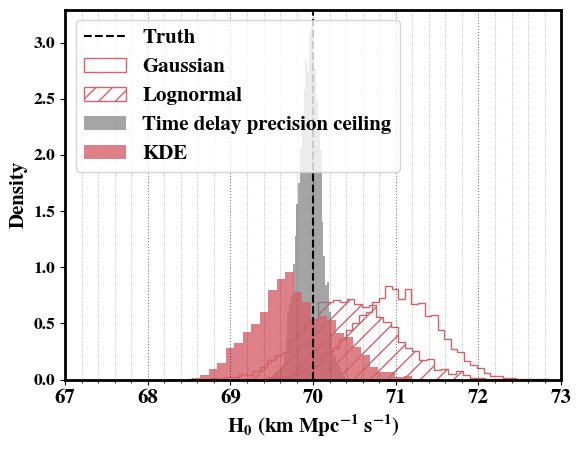

In [26]:
plt.close('all')

fig, ax = plt.subplots()

gaussian_samples = np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(3), 'combined_H0_summary.npy'))
gaussian_bins = np.histogram_bin_edges(gaussian_samples, bins='scott')
ax.hist(gaussian_samples, bins=gaussian_bins,  density=True, label='Gaussian', histtype='step', color='#d6616b', )

lognormal_samples = np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(3), 'combined_H0_summary_lognormal.npy'))
lognormal_bins = np.histogram_bin_edges(lognormal_samples, bins='scott')
ax.hist(lognormal_samples, bins=lognormal_bins,  density=True, label='Lognormal', histtype='step', color='#d6616b', hatch='//')

#plt.hist(h0_samples_kde['prec']['all'], bins=25, density=True, label='Time delay precision ceiling', histtype='stepfilled', color='tab:gray')
prec_lower = np.quantile(h0_samples_kde['prec']['all'], q=0.5 - 0.341, keepdims=False) 
prec_upper = np.quantile(h0_samples_kde['prec']['all'], q=0.5 + 0.341, keepdims=False) 
print(prec_lower, prec_upper)
y2 = [5, 5]
y1 = [0, 0]
#plt.fill_between(prec_lower + prec_upper, y2, y1, where=y2>y1, alpha=0.4, color='tab:gray', label='Time delay precision ceiling')
#plt.fill_betweenx([0, 10], prec_lower, prec_upper, alpha=1, color='tab:gray', label='Time delay precision ceiling')
prec_bins = np.histogram_bin_edges(h0_samples_kde['prec']['all'], bins='scott')
ax.hist(h0_samples_kde['prec']['all'], bins=prec_bins, alpha=0.7, density=True, label='Time delay precision ceiling', color='tab:gray')


#plt.ylim([0, 1.0])
#plt.title('All')
ax.axvline(70, color='k', linestyle='--', label='Truth')
h0_samples = np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(3), 'combined_H0_summary_kde.npy'))
kde_bins = np.histogram_bin_edges(h0_samples, bins='scott')
ax.hist(h0_samples, bins=kde_bins, alpha=0.8, density=True, label='KDE', color='#d6616b')
plt.xlim([67, 73])
plt.xlabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)")
plt.ylabel('Density')
plt.xticks(np.arange(67, 73 + 1, 1), fontsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="x", color="black", alpha=.5,  linestyle='dotted')
ax.grid(axis="x", color="black", which='minor', alpha=.2,  linestyle=(0, (1, 1)))
plt.legend(fontsize=15, loc='upper left')
plt.show()
#fig.savefig('../kde_vs_lognormal_vs_normal_hist.png', bbox_inches='tight', pad_inches=0)

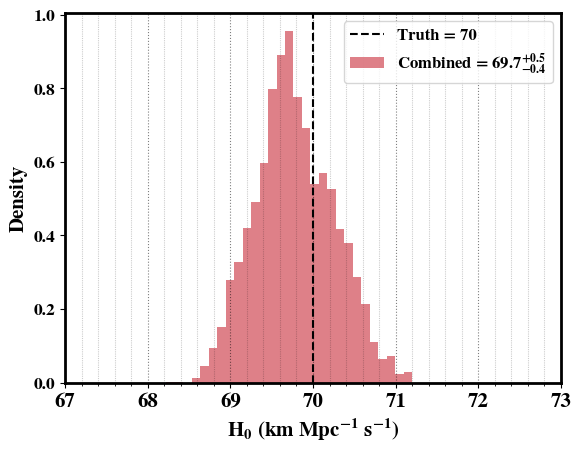

In [34]:
plt.close('all')

fig, ax = plt.subplots()

ax.axvline(70, color='k', linestyle='--', label='Truth = 70')
h0_samples = np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(3), 'combined_H0_summary_kde.npy'))
kde_bins = np.histogram_bin_edges(h0_samples, bins='scott')
ax.hist(h0_samples, bins=kde_bins, alpha=0.8, density=True, label='Combined = $69.7^{+0.5}_{-0.4}$', color='#d6616b')
plt.xlim([67, 73])
plt.xlabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)")
plt.ylabel('Density')
plt.xticks(np.arange(67, 73 + 1, 1), fontsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="x", color="black", alpha=.5,  linestyle='dotted')
ax.grid(axis="x", color="black", which='minor', alpha=.2,  linestyle=(0, (1, 1)))
plt.legend(fontsize=12, loc='upper right')
plt.show()
#fig.savefig('../kde_vs_lognormal_vs_normal_hist.png', bbox_inches='tight', pad_inches=0)

0.5 doubles [69.05642034] [69.90586399] [68.22171133] [0.84944365]
0.5 quads [70.01794158] [70.7696125] [69.27211503] [0.75167092]
1 doubles [69.43271947] [70.245255] [68.64000667] [0.81253553]
1 quads [69.87715227] [70.56572064] [69.1965585] [0.68856837]
2 doubles [69.82826991] [70.66424951] [68.9956608] [0.83597961]
2 quads [70.54869561] [71.41743279] [69.64925174] [0.86873718]
[<matplotlib.lines.Line2D object at 0x7f19d29c9a90>, <matplotlib.lines.Line2D object at 0x7f19d2ce9d30>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>] [' ', 'Truth = 70 km Mpc$^{-1}$ s$^{-1}$', '0.5 HST orbit', '0.5 HST orbit', '1 HST orbit', '1 HST orbit', '2 HST orbit', '2 HST orbit', 'Time delay precision ceiling', 'Time delay pre

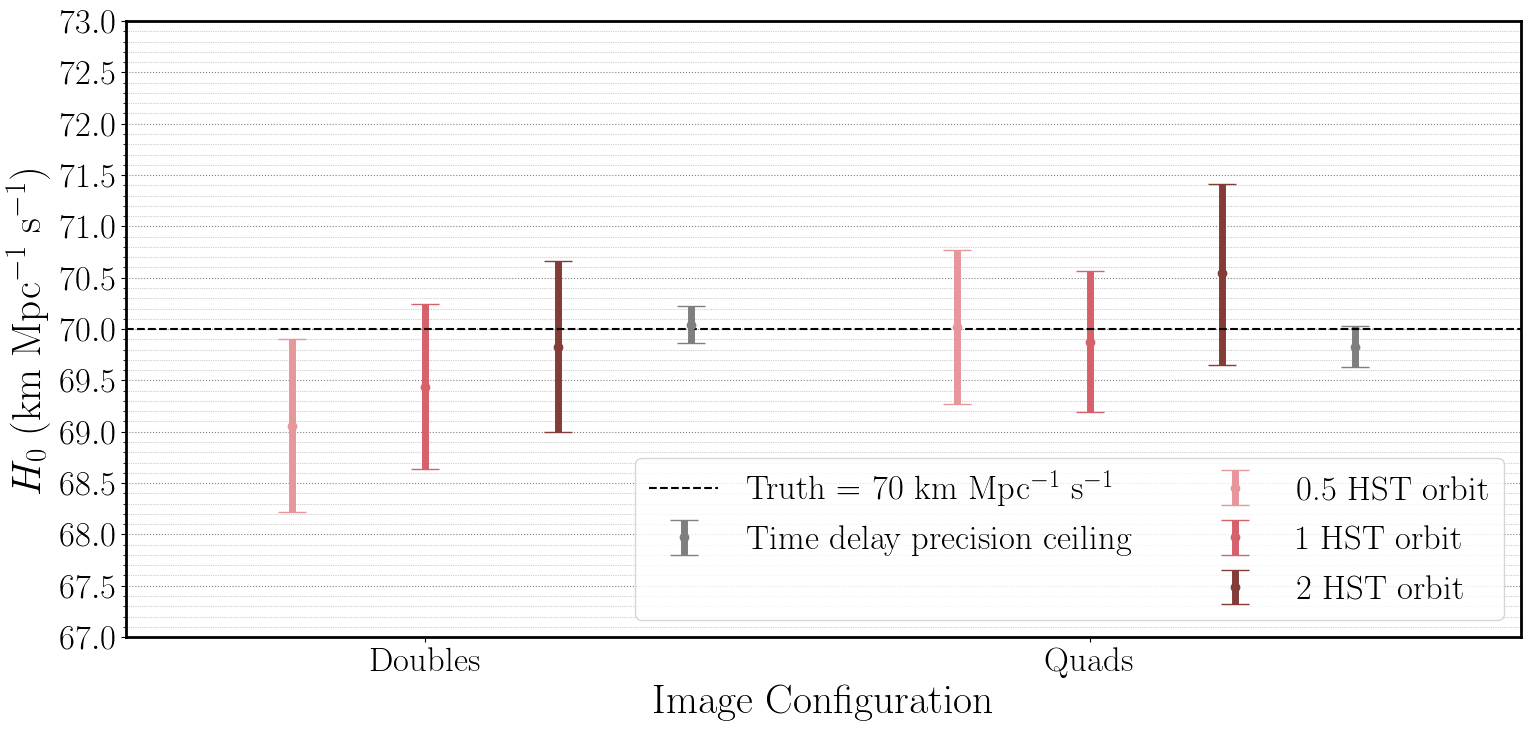

In [110]:


plt.close('all')
fig, ax = plt.subplots(figsize=(18, 8))
n_bins = len(img_conf_available)

# 1-sigma for each exptime, kde
for orbit_i, orbit in enumerate(orbits_available):
    for conf_i, conf in enumerate(img_conf_available):
        means = np.mean(h0_samples_kde[orbit][conf], keepdims=True)
        #stds = np.std(h0_samples_lognormal[orbit][conf], keepdims=True)
        upper_sig = np.quantile(h0_samples_kde[orbit][conf], q=0.5 + 0.341, keepdims=True)
        lower_sig = np.quantile(h0_samples_kde[orbit][conf], q=0.5 - 0.341, keepdims=True)
        print(orbit, conf, means, upper_sig, lower_sig, upper_sig - means)
        plt.errorbar(conf_to_x_pos[conf] + orbit_i*0.2 - 0.2, means, yerr=[means-lower_sig, upper_sig-means], fmt='o', color=orbit_to_color[orbit], lw=5, capsize=10, label='{:s} HST orbit'.format(str(orbit)))

if False:
    # 1-sigma for each exptime, lognormal
    for orbit_i, orbit in enumerate(orbits_available):
        for conf_i, conf in enumerate(img_conf_available):
            means = np.mean(h0_samples_lognormal[orbit][conf], keepdims=True)
            #stds = np.std(h0_samples_lognormal[orbit][conf], keepdims=True)
            upper_sig = np.quantile(h0_samples_lognormal[orbit][conf], q=0.5 + 0.341, keepdims=True)
            lower_sig = np.quantile(h0_samples_lognormal[orbit][conf], q=0.5 - 0.341, keepdims=True)
            print(orbit, conf, means, upper_sig, lower_sig, upper_sig - means)
            plt.errorbar(conf_to_x_pos[conf] + orbit_i*0.2 - 0.2, means, yerr=[means-lower_sig, upper_sig-means],
                         fmt='o', color=orbit_to_color[orbit], lw=3, capsize=10, label='Lognormal, {:s} HST orbit'.format(str(orbit)))

    # 1-sigma for each exptime, normal
    for orbit_i, orbit in enumerate(orbits_available):
        for conf_i, conf in enumerate(img_conf_available):
            means = np.mean(h0_samples_normal[orbit][conf], keepdims=True)
            #stds = np.std(h0_samples_lognormal[orbit][conf], keepdims=True)
            upper_sig = np.quantile(h0_samples_normal[orbit][conf], q=0.5 + 0.341, keepdims=True)
            lower_sig = np.quantile(h0_samples_normal[orbit][conf], q=0.5 - 0.341, keepdims=True)
            print(orbit, conf, means, upper_sig, lower_sig, upper_sig - means)
            l, caps, c = plt.errorbar(conf_to_x_pos[conf] + orbit_i*0.2 - 0.2 + 0.05, means, yerr=[means-lower_sig, upper_sig-means], fmt='o', color=orbit_to_color[orbit], lw=3, capsize=10, label='Normal, {:s}'.format(orbit_to_seconds[orbit]))
            caps[0].set_marker('^')
            caps[1].set_marker('v')
            c[0].set_linestyle('--')

if include_prec_ceiling:
    for conf_i, conf in enumerate(img_conf_available):
        prec_means = np.mean(h0_samples_kde['prec'][conf], keepdims=True)
        prec_upper_sig = np.quantile(h0_samples_kde['prec'][conf], q=0.5 + 0.341, keepdims=True) 
        prec_lower_sig = np.quantile(h0_samples_kde['prec'][conf], q=0.5 - 0.341, keepdims=True) 
        plt.errorbar(conf_to_x_pos[conf] + 0.4, prec_means, yerr=[prec_means-prec_lower_sig, prec_upper_sig-prec_means], fmt='o', color='tab:gray', alpha=1.0, lw=5, capsize=10, label=r'Time delay precision ceiling')

plt.plot(np.NaN, np.NaN, '-', color='none', label=' ')
# Axis labels, ticks
xlabels = ['Doubles', 'Quads']
plt.xticks(np.arange(n_bins), labels=xlabels, fontsize=25)
plt.xlim([-0.45, len(xlabels) + -1 + 0.65])
plt.yticks(np.arange(67, 73 + 1, 0.5), fontsize=25)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')
ax.grid(axis="y", color="black", which='minor', alpha=.2,  linestyle=(0, (1, 1)))
plt.ylim([67, 73])

plt.axhline(70.0, c='k', linestyle='--', label='Truth = 70 km Mpc$^{-1}$ s$^{-1}$')
plt.ylabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)", fontsize=30)
plt.xlabel("Image Configuration", fontsize=30)
#plt.ylabel("$H_0\:(\\textbf{km Mpc}^{-1}\:\\textbf{s}^{-1})$")
plt.legend(loc='lower right', ncol=3)
handles, legend_labels = plt.gca().get_legend_handles_labels()
print(handles, legend_labels)
#order = [0, 5, 1, 2, 3, 4]
#order = [ -1, 1,0, 3, 5, 7, -7, -5, -3]
order = [1, -1, 0, 2, 4, 6]
plt.legend([handles[idx] for idx in order], [legend_labels[idx] for idx in order], loc='lower right', fontsize=25, ncol=2)
plt.savefig('../boxplot_doubles_vs_quads.png', bbox_inches='tight', pad_inches=0) #dpi=1200)

plt.show()

2 doubles [69.82826991] [70.66424951] [68.9956608] [0.83597961]
2 quads [70.54869561] [71.41743279] [69.64925174] [0.86873718]
[<matplotlib.lines.Line2D object at 0x7f1a719197b8>, <matplotlib.lines.Line2D object at 0x7f19d2600208>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>] [' ', 'Truth = 70 km Mpc$^{-1}$ s$^{-1}$', '2 HST orbit', '2 HST orbit', 'Time delay precision ceiling', 'Time delay precision ceiling']


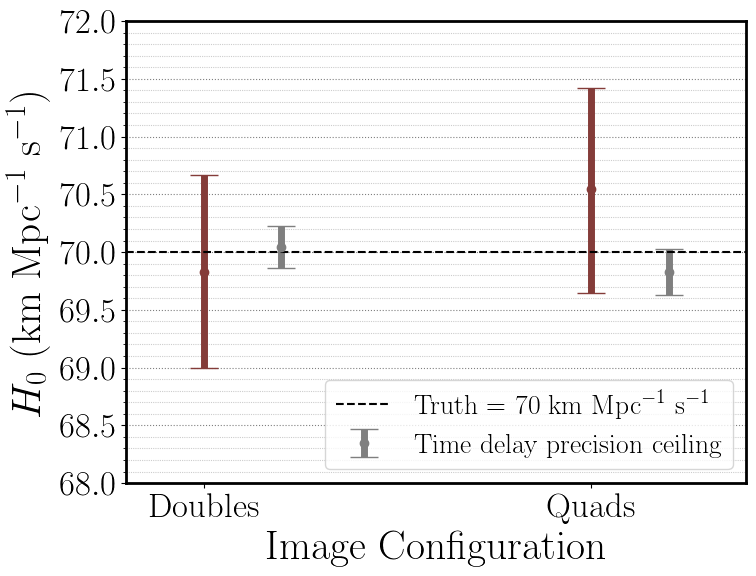

In [107]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.close('all')
fig, ax = plt.subplots(figsize=(8, 6))
n_bins = len(img_conf_available)

# 1-sigma for each exptime, kde
for orbit_i, orbit in enumerate([2]):
    for conf_i, conf in enumerate(img_conf_available):
        means = np.mean(h0_samples_kde[orbit][conf], keepdims=True)
        #stds = np.std(h0_samples_lognormal[orbit][conf], keepdims=True)
        upper_sig = np.quantile(h0_samples_kde[orbit][conf], q=0.5 + 0.341, keepdims=True)
        lower_sig = np.quantile(h0_samples_kde[orbit][conf], q=0.5 - 0.341, keepdims=True)
        print(orbit, conf, means, upper_sig, lower_sig, upper_sig - means)
        plt.errorbar(conf_to_x_pos[conf] + orbit_i*0.2, means, yerr=[means-lower_sig, upper_sig-means], fmt='o', color=orbit_to_color[orbit], lw=5, capsize=10, label='{:s} HST orbit'.format(str(orbit)))

if False:
    # 1-sigma for each exptime, lognormal
    for orbit_i, orbit in enumerate(orbits_available):
        for conf_i, conf in enumerate(img_conf_available):
            means = np.mean(h0_samples_lognormal[orbit][conf], keepdims=True)
            #stds = np.std(h0_samples_lognormal[orbit][conf], keepdims=True)
            upper_sig = np.quantile(h0_samples_lognormal[orbit][conf], q=0.5 + 0.341, keepdims=True)
            lower_sig = np.quantile(h0_samples_lognormal[orbit][conf], q=0.5 - 0.341, keepdims=True)
            print(orbit, conf, means, upper_sig, lower_sig, upper_sig - means)
            plt.errorbar(conf_to_x_pos[conf] + orbit_i*0.2 - 0.2, means, yerr=[means-lower_sig, upper_sig-means],
                         fmt='o', color=orbit_to_color[orbit], lw=3, capsize=10, label='Lognormal, {:s} HST orbit'.format(str(orbit)))

    # 1-sigma for each exptime, normal
    for orbit_i, orbit in enumerate(orbits_available):
        for conf_i, conf in enumerate(img_conf_available):
            means = np.mean(h0_samples_normal[orbit][conf], keepdims=True)
            #stds = np.std(h0_samples_lognormal[orbit][conf], keepdims=True)
            upper_sig = np.quantile(h0_samples_normal[orbit][conf], q=0.5 + 0.341, keepdims=True)
            lower_sig = np.quantile(h0_samples_normal[orbit][conf], q=0.5 - 0.341, keepdims=True)
            print(orbit, conf, means, upper_sig, lower_sig, upper_sig - means)
            l, caps, c = plt.errorbar(conf_to_x_pos[conf] + orbit_i*0.2 - 0.2 + 0.05, means, yerr=[means-lower_sig, upper_sig-means], fmt='o', color=orbit_to_color[orbit], lw=3, capsize=10, label='Normal, {:s}'.format(orbit_to_seconds[orbit]))
            caps[0].set_marker('^')
            caps[1].set_marker('v')
            c[0].set_linestyle('--')

if include_prec_ceiling:
    for conf_i, conf in enumerate(img_conf_available):
        prec_means = np.mean(h0_samples_kde['prec'][conf], keepdims=True)
        prec_upper_sig = np.quantile(h0_samples_kde['prec'][conf], q=0.5 + 0.341, keepdims=True) 
        prec_lower_sig = np.quantile(h0_samples_kde['prec'][conf], q=0.5 - 0.341, keepdims=True) 
        plt.errorbar(conf_to_x_pos[conf] + 0.2, prec_means, yerr=[prec_means-prec_lower_sig, prec_upper_sig-prec_means], fmt='o', color='tab:gray', alpha=1.0, lw=5, capsize=10, label=r'Time delay precision ceiling')

plt.plot(np.NaN, np.NaN, '-', color='none', label=' ')
# Axis labels, ticks
xlabels = ['Doubles', 'Quads']
plt.xticks(np.arange(n_bins), labels=xlabels, fontsize=25)
plt.xlim([-0.2, 1.4])
plt.yticks(np.arange(67, 73 + 1, 0.5), fontsize=25)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')
ax.grid(axis="y", color="black", which='minor', alpha=.2,  linestyle=(0, (1, 1)))
plt.ylim([68, 72])

plt.axhline(70.0, c='k', linestyle='--', label='Truth = 70 km Mpc$^{-1}$ s$^{-1}$')
plt.ylabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)", fontsize=30)
plt.xlabel("Image Configuration", fontsize=30)
#plt.ylabel("$H_0\:(\\textbf{km Mpc}^{-1}\:\\textbf{s}^{-1})$")
plt.legend(loc='lower right', ncol=3)
handles, legend_labels = plt.gca().get_legend_handles_labels()
print(handles, legend_labels)
#order = [0, 5, 1, 2, 3, 4]
#order = [ -1, 1,0, 3, 5, 7, -7, -5, -3]
order = [1, -1] #0, 2, 4, 6]
plt.legend([handles[idx] for idx in order], [legend_labels[idx] for idx in order], loc='lower right', fontsize=20, ncol=1)
plt.savefig('../boxplot_doubles_vs_quads.png', bbox_inches='tight', pad_inches=0) #dpi=1200)

plt.show()

### Exposure times <a name="exposure_times"></a>

0.5 [69.66539546] [0.56229201]
1 [69.78062091] [0.48452547]
2 [70.27993611] [0.57793086]
[<matplotlib.lines.Line2D object at 0x7f19d06931d0>, <matplotlib.lines.Line2D object at 0x7f19d2643978>, <matplotlib.collections.PolyCollection object at 0x7f19d2be32e8>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>] [' ', 'Truth = 70 km Mpc$^{-1}$ s$^{-1}$', 'Time delay precision ceiling', '0.5 HST orbit', '1 HST orbit', '2 HST orbit']


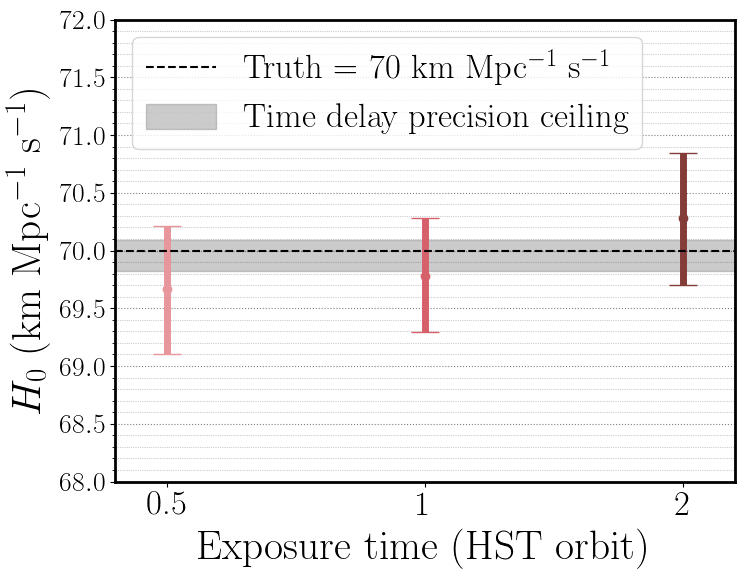

In [111]:
plt.close('all')
fig, ax = plt.subplots(figsize=(8, 6))

# 1-sigma for each exptime, KDE
for orbit_i, orbit in enumerate(orbits_available):
    means = np.mean(h0_samples_kde[orbit]['all'], keepdims=True)
    #stds = np.std(h0_samples[orbit]['all'], keepdims=True)
    upper_sig = np.quantile(h0_samples_kde[orbit]['all'], q=0.5 + 0.341, keepdims=True)
    lower_sig = np.quantile(h0_samples_kde[orbit]['all'], q=0.5 - 0.341, keepdims=True)
    plt.errorbar(orbit_i , means, yerr=[means-lower_sig, upper_sig-means], fmt='o', color=orbit_to_color[orbit], lw=5, capsize=10, label='{:s} HST orbit'.format(str(orbit)))
    print(orbit, means, means-lower_sig)
if False:
    # 1-sigma for each exptime, lognormal
    for orbit_i, orbit in enumerate(orbits_available):
        means = np.mean(h0_samples_lognormal[orbit]['all'], keepdims=True)
        #stds = np.std(h0_samples[orbit]['all'], keepdims=True)
        upper_sig = np.quantile(h0_samples_lognormal[orbit]['all'], q=0.5 + 0.341, keepdims=True)
        lower_sig = np.quantile(h0_samples_lognormal[orbit]['all'], q=0.5 - 0.341, keepdims=True)
        plt.errorbar(orbit_i + 0.05 , means, yerr=[means-lower_sig, upper_sig-means], fmt='o', color=orbit_to_color[orbit], lw=5, capsize=10, label='Lognormal, {:s}'.format(orbit_to_seconds[orbit]))
        print(orbit, means, means-lower_sig)

    for orbit_i, orbit in enumerate(orbits_available):
        means = np.mean(h0_samples_normal[orbit]['all'], keepdims=True)
        #stds = np.std(h0_samples[orbit]['all'], keepdims=True)
        upper_sig = np.quantile(h0_samples_normal[orbit]['all'], q=0.5 + 0.341, keepdims=True)
        lower_sig = np.quantile(h0_samples_normal[orbit]['all'], q=0.5 - 0.341, keepdims=True)
        eb = plt.errorbar(orbit_i + 0.05, means, yerr=[means-lower_sig, upper_sig-means], fmt='o', color=orbit_to_color[orbit], lw=3, capsize=10, label='Normal, {:s}'.format(orbit_to_seconds[orbit]))
        eb[-1][0].set_linestyle('--')

if include_prec_ceiling:
    prec_means = np.mean(h0_samples_kde['prec']['all'], keepdims=True)
    prec_upper_sig = np.quantile(h0_samples_kde['prec']['all'], q=0.5 + 0.341, keepdims=True) 
    prec_lower_sig = np.quantile(h0_samples_kde['prec']['all'], q=0.5 - 0.341, keepdims=True) 
    #plt.errorbar(conf_to_x_pos['all'] + 0.2, prec_means, yerr=[prec_upper_sig-prec_means, prec_means-prec_lower_sig], fmt='o', color='tab:gray', alpha=1.0, lw=3, capsize=5, label=r'Time delay precision ceiling')
    #plt.plot(orbit_i, prec_means, color='tab:gray', linestyle='dotted')
plt.fill_between([-0.3, 1, 2.2], prec_lower_sig, prec_upper_sig, color='tab:gray', alpha=0.4, label='Time delay precision ceiling')

plt.plot(np.NaN, np.NaN, '-', color='none', label=' ')

plt.xticks(np.arange(len(orbits_available)), labels=['{:s}'.format(str(o)) for o in orbits_available], fontsize=25)
plt.yticks(np.arange(68, 72 + 1, 0.5))

plt.xlim([-0.2, 2.2])
plt.ylim([68, 72])

from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')
ax.grid(axis="y", color="black", which='minor', alpha=.2,  linestyle=(0, (1, 1)))

#plt.title("Combined $H_0$ predictions")
plt.axhline(70.0, c='k', linestyle='--', label='Truth = 70 km Mpc$^{-1}$ s$^{-1}$')
plt.ylabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)", fontsize=30)
plt.xlabel("Exposure time (HST orbit)", fontsize=30)
#plt.legend(loc='lower right')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2]

print(handles, labels)#set_color('#da5054')

handles[-1]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', ncol=1, fontsize=25)
plt.savefig('../boxplot_exptime.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [87]:
['{:s}'.format(str(orbit)) for o in orbits_available], orbits_available

(['2', '2', '2'], [0.5, 1, 2])

### Gamma retrieval vs. Einstein ring brightness <a name="gamma"></a>

For convenience, let's merge `metadata` (true parameters) with `summary` (containing the Einstein brightness bin).

In [46]:
def get_version_info(version_id, n_test=200):
    version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_id)
    test_cfg_path = os.path.join(version_dir, 'mcmc_default.json')
    test_cfg = TestConfig.from_file(test_cfg_path)
    baobab_cfg = BaobabConfig.from_file(test_cfg.data.test_baobab_cfg_path)
    #train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)
    # Read in truth metadata
    metadata = pd.read_csv(os.path.join(baobab_cfg.out_dir, 'metadata.csv'), index_col=None, nrows=n_test)
    # Read in summary
    summary = pd.read_csv(os.path.join(version_dir, 'summary.csv'), index_col=None, nrows=n_test)
    # Assign lens ID based on the row index of metadata, for merging with summary
    metadata['id'] = metadata.index
    summary_pred = summary.merge(metadata, on='id', suffixes=['', '_meta'], how='inner')
    # Precision ceiling
    prec_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(prec_version_id)
    prec_summary = pd.read_csv(os.path.join(prec_version_dir, 'ering_summary.csv'), index_col=None, nrows=n_test)
    summary_pred['lensed_E_ring_mag'] = prec_summary['lensed_E_ring_mag'].values
    
    lensed_ring_bins = np.quantile(summary_pred['lensed_E_ring_mag'].values, [0.25, 0.5, 0.75, 1])
    print(lensed_ring_bins, np.min(summary_pred['lensed_E_ring_mag'].values))
    lensed_ring_bins[-1] += 0.1 # buffer 
    summary_pred['lensed_ring_bin'] = np.digitize(summary_pred['lensed_E_ring_mag'].values, lensed_ring_bins)
    # Note that metadata stores the absolute source position, so get relative to lens center
    summary_pred['src_light_center_x'] -= summary_pred['lens_mass_center_x']
    summary_pred['src_light_center_y'] -= summary_pred['lens_mass_center_y'] 
    print(summary_pred.shape)
    #print(summary_pred.columns)
    # Read in the MC dropout BNN samples 
    samples = np.load('/home/jwp/stage/sl/h0rton/experiments/v{:d}/mcmc_default_samples_test_drop=0.001/samples.npy'.format(version_id))
    print(samples.shape) # [batch_size, n_walkers=n_dropout_samples, samples_per_dropout, Y_dim]
    print(samples.transpose(0, 3, 1, 2).shape) # [batch_size, Y_dim, n_walkers=n_dropout_samples, samples_per_dropout]
    n_lenses = samples.shape[0]
    mcmc_Y_dim = samples.shape[-1]
    n_test = 200
    samples = samples.transpose(0, 3, 1, 2).reshape([n_lenses, mcmc_Y_dim, -1])[:n_test]
    print(samples.shape)
    print(samples[0, 4, :5], train_val_cfg.data.Y_cols[4]) # 4=gamma column idx, values should be around 2
    #reshape([200, len(train_val_cfg.data.Y_cols), -1])

    # Store BNN predictions (expected value and spread) as dataframes
    pred_mean = np.mean(samples, axis=-1) # expected value
    pred_std = np.std(samples, axis=-1)
    params_to_remove = [] #'src_light_R_sersic'] 
    mcmc_Y_cols = [col for col in train_val_cfg.data.Y_cols if col not in params_to_remove]
    pred_mean = pd.DataFrame(pred_mean, columns=mcmc_Y_cols)
    pred_std = pd.DataFrame(pred_std, columns=mcmc_Y_cols)
    pred_mean = sim_utils.add_qphi_columns(pred_mean)
    pred_mean = sim_utils.add_gamma_psi_ext_columns(pred_mean)
    
    version_info = dict(
        summary_pred=summary_pred,
        samples=samples,
        pred_mean=pred_mean,
        pred_std=pred_std
    )
    return version_info

[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.91703297 1.76851033 1.95227655 1.9160991  2.00255598] lens_mass_gamma
[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.94560492 1.69237897 1.97748229 1.86145472 2.01299844] lens_mass_gamma
[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.91925142 1.69969817 1.96221046 1.91665722 2.02520254] lens_mass_gamma


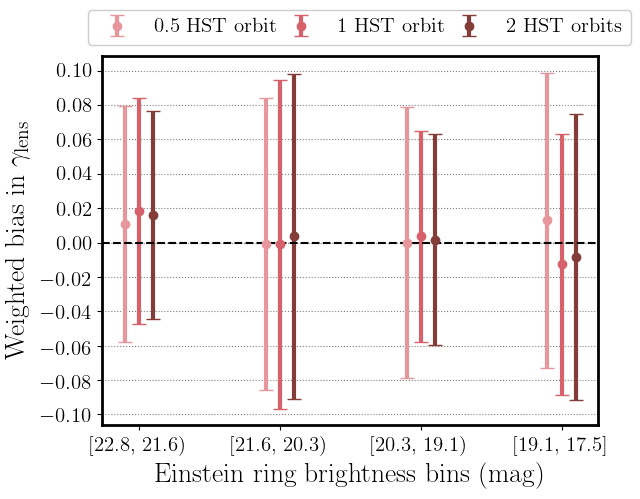

In [66]:
plt.close('all')
param_name = 'lens_mass_gamma'
param_label = '$\gamma_{\mathrm{lens}}$'

for orbit_i, orbit in enumerate(orbits_available):
    version_info = get_version_info(orbit_to_ver[orbit])
    # Bias = predicted - truth
    version_info['summary_pred']['{:s}_bias'.format(param_name)] = version_info['pred_mean'][param_name] - version_info['summary_pred'][param_name]
    centers = []
    yerr_lower = []
    yerr_upper = []
    pm = [] # plus minus (error bars)
    for bin_i in range(4): # again, brightest is bin 0
        binned_pred = version_info['summary_pred'][version_info['summary_pred']['lensed_ring_bin']==bin_i]
        binned_std = version_info['pred_std'][version_info['summary_pred']['lensed_ring_bin']==bin_i]
        center = np.average(binned_pred['{:s}_bias'.format(param_name)].values, weights=1.0/binned_std[param_name].values**2.0)
        weighted_std = np.average((binned_pred['{:s}_bias'.format(param_name)].values - center)**2.0, weights=1.0/binned_std[param_name].values**2.0)**0.5
        #print(center, weighted_std)
        centers.append(center)
        pm.append(weighted_std)
        yerr_lower.append(center - weighted_std)
        yerr_upper.append(center + weighted_std)
    orbit_label = '{:s} HST orbit'.format(str(orbit)) if orbit < 2 else '{:s} HST orbits'.format(str(orbit))
    plt.errorbar(np.array([3, 2, 1, 0]) + orbit_i*0.1 - 0.2, centers, yerr=pm, fmt='o', color=orbit_to_color[orbit], alpha=1.0, lw=3, capsize=5, label=orbit_label)

#labels = ['Fainter',  'Brighter']
#plt.xticks([0, 2.8], labels=labels, fontsize=15)

labels = ['[22.8, 21.6)', '[21.6, 20.3)', '[20.3, 19.1)', '[19.1, 17.5]']
plt.xticks(np.array([0, 1, 2, 3]) - 0.1, labels=labels, fontsize=15)

#print(centers, yerr_lower, yerr_upper)
plt.xlabel("Einstein ring brightness bins (mag)", fontsize=20)

plt.axhline(0, c='k', linestyle='--')
plt.yticks(np.linspace(-0.1, 0.1, 11), fontsize=15)
plt.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')

#plt.minorticks_on()
plt.ylabel('Weighted bias in {:s}'.format(param_label), fontsize=20)
plt.legend(loc='lower left', framealpha=1.0, bbox_to_anchor=(-0.05, 1), ncol=3, columnspacing=0.1, fontsize=15)
plt.savefig('../gamma_ring_brightness.png', bbox_inches='tight', pad_inches=0) #dpi=1200)
plt.show()

### Gamma retrieval vs. other metrics <a name="gamma_other_metrics"></a>

We can also plot the gamma recovery as a function of the lens light brightness. Let's first bin by the lens light magnitude.

In [193]:
lens_light_bins = np.quantile(summary_pred['lens_light_magnitude'].values, [0.25, 0.5, 0.75, 1])
lens_light_bins[-1] += 0.1 # buffer 
summary_pred['lens_light_bins'] = np.digitize(summary_pred['lens_light_magnitude'].values, lens_light_bins)
print(lens_light_bins)

[17.46299929 18.00244109 18.53339066 19.09359779]


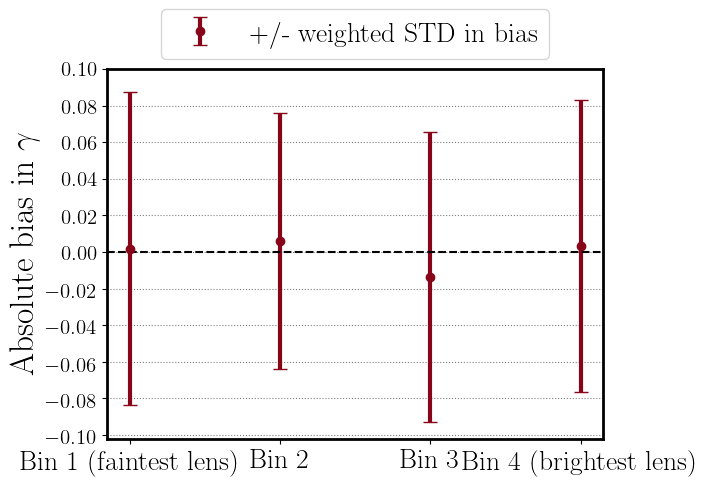

In [194]:
plt.close('all')
param_name = 'lens_mass_gamma'
param_label = '$\gamma$'

centers = []
yerr_lower = []
yerr_upper = []
pm = [] # plus minus (error bars)
for bin_i in range(4): # again, brightest is bin 0
    binned_pred = summary_pred[summary_pred['lens_light_bins']==bin_i]
    binned_std = pred_std[summary_pred['lens_light_bins']==bin_i]
    center = np.average(binned_pred['{:s}_bias'.format(param_name)].values, weights=1.0/binned_std[param_name].values**2.0)
    weighted_std = np.average((binned_pred['{:s}_bias'.format(param_name)].values - center)**2.0, weights=1.0/binned_std[param_name].values**2.0)**0.5
    #print(center, weighted_std)
    centers.append(center)
    pm.append(weighted_std)
    yerr_lower.append(center - weighted_std)
    yerr_upper.append(center + weighted_std)
labels = ['Bin 1 (faintest lens)', 'Bin 2', 'Bin 3', 'Bin 4 (brightest lens)']
plt.xticks(np.arange(4), labels=labels)
#print(centers, yerr_lower, yerr_upper)
plt.errorbar([3, 2, 1, 0], centers, yerr=pm, fmt='o', color=orbit_to_color[4], alpha=1.0, lw=3, capsize=5, label='+/- weighted STD in bias')
plt.axhline(0, c='k', linestyle='--')
plt.yticks(np.linspace(-0.1, 0.1, 11), fontsize=15)
plt.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')

plt.ylabel('Absolute bias in {:s}'.format(param_label))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

Do the same with image separation.

In [195]:
theta_E_bins = np.quantile(summary_pred['lens_mass_theta_E'].values, [0.25, 0.5, 0.75, 1])
theta_E_bins[-1] += 0.05 # buffer 
summary_pred['theta_E_bins'] = np.digitize(summary_pred['lens_mass_theta_E'].values, theta_E_bins)
print(theta_E_bins)

[1.02259621 1.09091348 1.15794779 1.4495651 ]


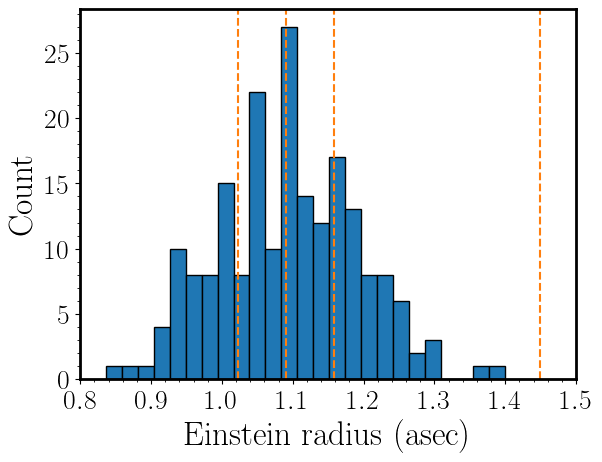

In [196]:
plt.close()
plt.hist(summary_pred['lens_mass_theta_E'], edgecolor='k', bins=25)
plt.xticks(np.linspace(0.8, 1.5, 8))
plt.minorticks_on()
#plt.gca().invert_xaxis()
for bin_edge in list(theta_E_bins):
    plt.axvline(bin_edge, color='tab:orange', linestyle='--')
plt.xlabel('Einstein radius (asec)')
plt.ylabel('Count')
plt.show()
if save_fig:
    plt.savefig(os.path.join(version_dir, 'ering_bins.png'), bbox_inches='tight', pad_inches=0)

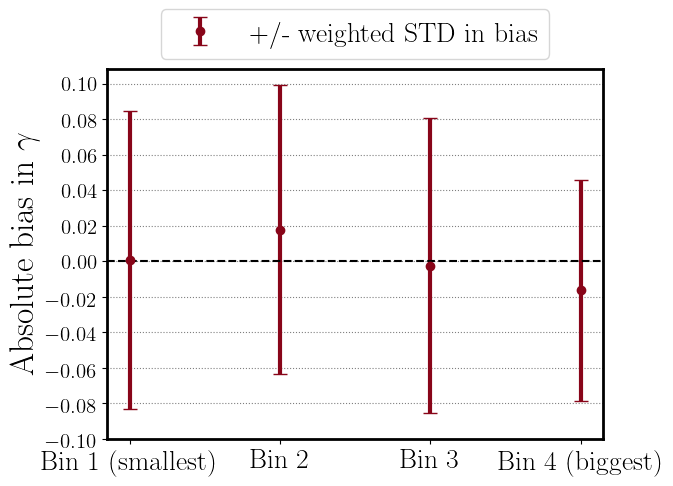

In [198]:
plt.close('all')
param_name = 'lens_mass_gamma'
param_label = '$\gamma$'

centers = []
yerr_lower = []
yerr_upper = []
pm = [] # plus minus (error bars)
for bin_i in range(4): # again, brightest is bin 0
    binned_pred = summary_pred[summary_pred['theta_E_bins']==bin_i]
    binned_std = pred_std[summary_pred['theta_E_bins']==bin_i]
    center = np.average(binned_pred['{:s}_bias'.format(param_name)].values, weights=1.0/binned_std[param_name].values**2.0)
    weighted_std = np.average((binned_pred['{:s}_bias'.format(param_name)].values - center)**2.0, weights=1.0/binned_std[param_name].values**2.0)**0.5
    #print(center, weighted_std)
    centers.append(center)
    pm.append(weighted_std)
    yerr_lower.append(center - weighted_std)
    yerr_upper.append(center + weighted_std)
labels = ['Bin 1 (smallest)', 'Bin 2', 'Bin 3', 'Bin 4 (biggest)']
plt.xticks(np.arange(4), labels=labels)
#print(centers, yerr_lower, yerr_upper)
plt.errorbar([0, 1, 2, 3], centers, yerr=pm, fmt='o', color=orbit_to_color[4], alpha=1.0, lw=3, capsize=5, label='+/- weighted STD in bias')
plt.axhline(0, c='k', linestyle='--')
plt.yticks(np.linspace(-0.1, 0.1, 11), fontsize=15)
plt.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')

plt.ylabel('Absolute bias in {:s}'.format(param_label))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

In [199]:
theta_E_bins = np.quantile(summary_pred['lens_mass_theta_E'].values, [1/5.0*(i+1) for i in range(5)])
theta_E_bins[-1] += 0.05 # buffer 
summary_pred['theta_E_bins'] = np.digitize(summary_pred['lens_mass_theta_E'].values, theta_E_bins)
print(theta_E_bins)

[1.00909678 1.06658093 1.11356445 1.18074172 1.4495651 ]


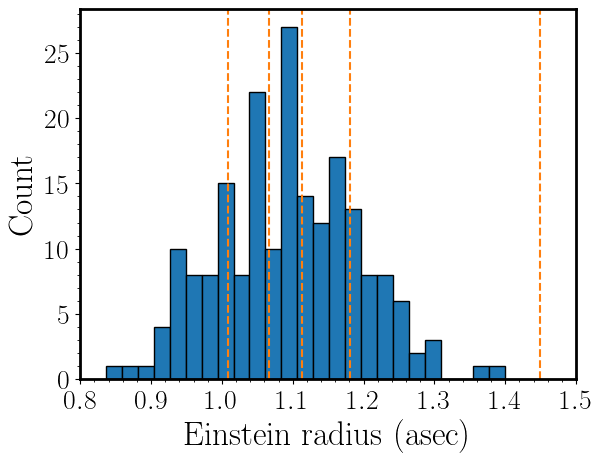

In [200]:
plt.close()
plt.hist(summary_pred['lens_mass_theta_E'], edgecolor='k', bins=25)
plt.xticks(np.linspace(0.8, 1.5, 8))
plt.minorticks_on()
#plt.gca().invert_xaxis()
for bin_edge in list(theta_E_bins):
    plt.axvline(bin_edge, color='tab:orange', linestyle='--')
plt.xlabel('Einstein radius (asec)')
plt.ylabel('Count')
plt.show()
if save_fig:
    plt.savefig(os.path.join(version_dir, 'ering_bins.png'), bbox_inches='tight', pad_inches=0)

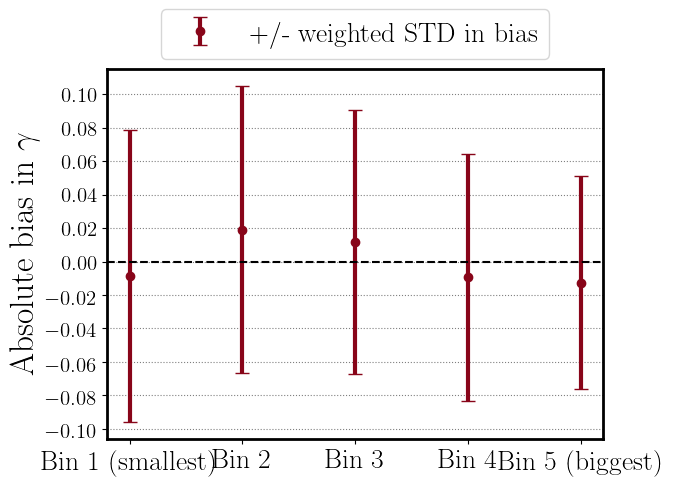

In [201]:
plt.close('all')
param_name = 'lens_mass_gamma'
param_label = '$\gamma$'

centers = []
yerr_lower = []
yerr_upper = []
pm = [] # plus minus (error bars)
for bin_i in range(5): # again, brightest is bin 0
    binned_pred = summary_pred[summary_pred['theta_E_bins']==bin_i]
    binned_std = pred_std[summary_pred['theta_E_bins']==bin_i]
    center = np.average(binned_pred['{:s}_bias'.format(param_name)].values, weights=1.0/binned_std[param_name].values**2.0)
    weighted_std = np.average((binned_pred['{:s}_bias'.format(param_name)].values - center)**2.0, weights=1.0/binned_std[param_name].values**2.0)**0.5
    #print(center, weighted_std)
    centers.append(center)
    pm.append(weighted_std)
    yerr_lower.append(center - weighted_std)
    yerr_upper.append(center + weighted_std)
labels = ['Bin 1 (smallest)', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5 (biggest)']
plt.xticks(np.arange(5), labels=labels)
#print(centers, yerr_lower, yerr_upper)
plt.errorbar([0, 1, 2, 3, 4], centers, yerr=pm, fmt='o', color=orbit_to_color[4], alpha=1.0, lw=3, capsize=5, label='+/- weighted STD in bias')
plt.axhline(0, c='k', linestyle='--')
plt.yticks(np.linspace(-0.1, 0.1, 11), fontsize=15)
plt.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')

plt.ylabel('Absolute bias in {:s}'.format(param_label))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

... and doubles vs. quads.

[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.91703297 1.76851033 1.95227655 1.9160991  2.00255598] lens_mass_gamma
[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.94560492 1.69237897 1.97748229 1.86145472 2.01299844] lens_mass_gamma
[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.91925142 1.69969817 1.96221046 1.91665722 2.02520254] lens_mass_gamma


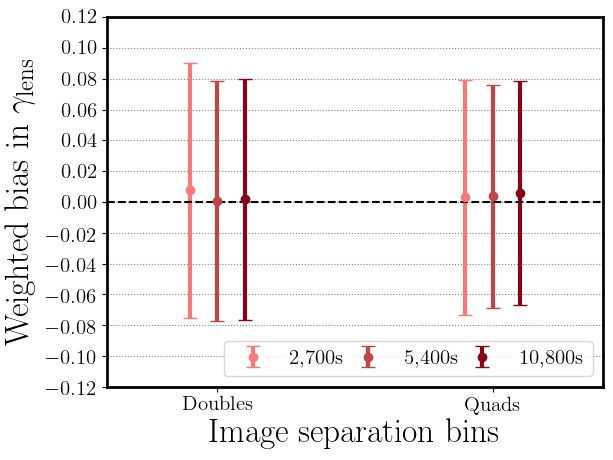

In [100]:
plt.close('all')
param_name = 'lens_mass_gamma'
param_label = '$\gamma_{\mathrm{lens}}$'

for orbit_i, orbit in enumerate(orbits_available):
    version_info = get_version_info(orbit_to_ver[orbit])
    # Bias = predicted - truth
    version_info['summary_pred']['{:s}_bias'.format(param_name)] = version_info['pred_mean'][param_name] - version_info['summary_pred'][param_name]
    centers = []
    yerr_lower = []
    yerr_upper = []
    pm = [] # plus minus (error bars)
    for n_img in [2, 4]: # smallest separation is bin 0
        binned_pred = version_info['summary_pred'][version_info['summary_pred']['n_img']==n_img]
        binned_std = version_info['pred_std'][version_info['summary_pred']['n_img']==n_img]
        center = np.average(binned_pred['{:s}_bias'.format(param_name)].values, weights=1.0/binned_std[param_name].values**2.0)
        weighted_std = np.average((binned_pred['{:s}_bias'.format(param_name)].values - center)**2.0, weights=1.0/binned_std[param_name].values**2.0)**0.5
        #print(center, weighted_std)
        centers.append(center)
        pm.append(weighted_std)
        yerr_lower.append(center - weighted_std)
        yerr_upper.append(center + weighted_std)
    plt.errorbar(np.array([0, 1]) + orbit_i*0.1 - 0.2, centers, yerr=pm, fmt='o', color=orbit_to_color[orbit], alpha=1.0, lw=3, capsize=5, label=orbit_to_seconds[orbit])

labels = ['Doubles', 'Quads']
plt.xticks([-0.1, 0.9], labels=labels, fontsize=15)
#print(centers, yerr_lower, yerr_upper)
plt.xlabel("Image separation bins")
plt.xlim([-0.5, 1.3])

plt.axhline(0, c='k', linestyle='--')
plt.yticks(np.linspace(-0.12, 0.12, 13), fontsize=15)
plt.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')

#plt.minorticks_on()
plt.ylabel('Weighted bias in {:s}'.format(param_label))
plt.legend(loc='lower right', columnspacing=0.1, ncol=3, fontsize=15)
plt.savefig('../gamma_theta_E.png', bbox_inches='tight', pad_inches=0) #dpi=1200)
plt.show()

What if we engineer a metric based on parameters that will make gamma easier to learn?

In [214]:
summary_pred.columns

Index(['Unnamed: 0', 'n_img', 'z_lens', 'z_src', 'id', 'D_dt_mu', 'D_dt_sigma',
       'H0_mean', 'H0_std', 'inference_time', 'D_dt_mean', 'D_dt_std', 'H0',
       'agn_light_magnitude', 'external_shear_dec_0',
       'external_shear_gamma_ext', 'external_shear_psi_ext',
       'external_shear_ra_0', 'img_filename', 'kappa_ext',
       'lens_light_R_sersic', 'lens_light_center_x', 'lens_light_center_y',
       'lens_light_e1', 'lens_light_e2', 'lens_light_magnitude',
       'lens_light_n_sersic', 'lens_mass_center_x', 'lens_mass_center_y',
       'lens_mass_e1', 'lens_mass_e2', 'lens_mass_gamma', 'lens_mass_theta_E',
       'lensed_total_flux_TDLMC_F160W', 'magnification',
       'measured_magnification', 'n_img_meta', 'src_light_R_sersic',
       'src_light_center_x', 'src_light_center_y', 'src_light_e1',
       'src_light_e2', 'src_light_magnitude', 'src_light_n_sersic',
       'total_magnification_TDLMC_F160W', 'true_td', 'true_vd',
       'unlensed_total_flux_TDLMC_F160W', 'x_image

In [216]:
#handpicked_metric = summary_pred['lens_mass_theta_E'].values*2.5**-((summary_pred['src_light_magnitude'].values - 20))*summary_pred['src_light_R_sersic']/summary_pred['lens_light_R_sersic'].values/2.5**(-(summary_pred['lens_light_magnitude'].values - 20))
handpicked_metric = (summary_pred['lens_mass_e1'].values**2.0 + summary_pred['lens_mass_e2'].values**2.0)**0.5
#handpicked_metric = summary_pred['lens_mass_theta_E'].values*summary_pred['lens_light_magnitude'].values*summary_pred['src_light_R_sersic']/summary_pred['lens_light_R_sersic'].values/summary_pred['src_light_magnitude'].values
#handpicked_metric = summary_pred['lens_mass_theta_E'].values/summary_pred['src_light_R_sersic']/summary_pred['src_light_magnitude'].values
#handpicked_metric = summary_pred['lens_mass_theta_E'].values/summary_pred['src_light_magnitude'].values
handpicked_metric_bins = np.quantile(handpicked_metric, [0.25, 0.5, 0.75, 1])
handpicked_metric_bins[-1] += 0.05 # buffer 
summary_pred['handpicked_metric_bins'] = np.digitize(handpicked_metric, handpicked_metric_bins)
print(handpicked_metric_bins)

[0.11503674 0.17812869 0.24581479 0.56369841]


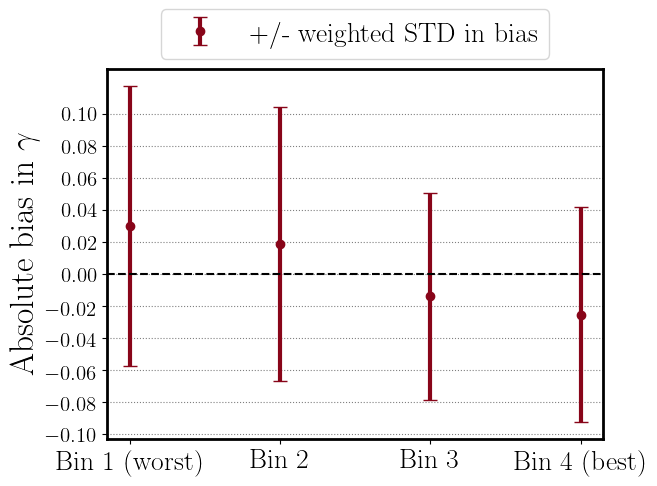

In [217]:
plt.close('all')
param_name = 'lens_mass_gamma'
param_label = '$\gamma$'

centers = []
yerr_lower = []
yerr_upper = []
pm = [] # plus minus (error bars)
for bin_i in range(4): # again, brightest is bin 0
    binned_pred = summary_pred[summary_pred['handpicked_metric_bins']==bin_i]
    binned_std = pred_std[summary_pred['handpicked_metric_bins']==bin_i]
    center = np.average(binned_pred['{:s}_bias'.format(param_name)].values, weights=1.0/binned_std[param_name].values**2.0)
    weighted_std = np.average((binned_pred['{:s}_bias'.format(param_name)].values - center)**2.0, weights=1.0/binned_std[param_name].values**2.0)**0.5
    #print(center, weighted_std)
    centers.append(center)
    pm.append(weighted_std)
    yerr_lower.append(center - weighted_std)
    yerr_upper.append(center + weighted_std)
labels = ['Bin 1 (worst)', 'Bin 2', 'Bin 3', 'Bin 4 (best)']
plt.xticks(np.arange(4), labels=labels)
#print(centers, yerr_lower, yerr_upper)
plt.errorbar([0, 1, 2, 3], centers, yerr=pm, fmt='o', color=orbit_to_color[4], alpha=1.0, lw=3, capsize=5, label='+/- weighted STD in bias')
plt.axhline(0, c='k', linestyle='--')
plt.yticks(np.linspace(-0.1, 0.1, 11), fontsize=15)
plt.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')

plt.ylabel('Absolute bias in {:s}'.format(param_label))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

In [56]:
#handpicked_metric = summary_pred['lens_mass_theta_E'].values*2.5**-((summary_pred['src_light_magnitude'].values - 20))*summary_pred['src_light_R_sersic']/summary_pred['lens_light_R_sersic'].values/2.5**(-(summary_pred['lens_light_magnitude'].values - 20))

#handpicked_metric = summary_pred['lens_mass_theta_E'].values*summary_pred['lens_light_magnitude'].values*summary_pred['src_light_R_sersic']/summary_pred['lens_light_R_sersic'].values/summary_pred['src_light_magnitude'].values
#handpicked_metric = summary_pred['lens_mass_theta_E'].values/summary_pred['src_light_R_sersic']/summary_pred['src_light_magnitude'].values
#handpicked_metric = summary_pred['lens_mass_theta_E'].values/summary_pred['src_light_magnitude'].values
handpicked_metric_bins = np.quantile(handpicked_metric, [0.25, 0.5, 0.75, 1])
handpicked_metric_bins[-1] += 0.05 # buffer 
summary_pred['handpicked_metric_bins'] = np.digitize(handpicked_metric, handpicked_metric_bins)
print(handpicked_metric_bins)

NameError: name 'summary_pred' is not defined

[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.91703297 1.76851033 1.95227655 1.9160991  2.00255598] lens_mass_gamma
[0.60538011 0.69760749 0.79366293 0.99087926] 0.3212671604203224
[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.94560492 1.69237897 1.97748229 1.86145472 2.01299844] lens_mass_gamma
[0.60538011 0.69760749 0.79366293 0.99087926] 0.3212671604203224
[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.91925142 1.69969817 1.96221046 1.91665722 2.02520254] lens_mass_gamma
[0.60538011 0.69760749 0.79366293 0.99087926] 0.3212671604203224


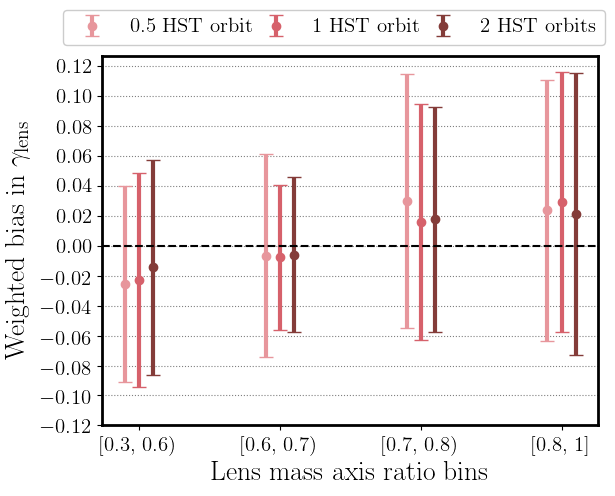

In [75]:
plt.close('all')
param_name = 'lens_mass_gamma'
param_label = '$\gamma_{\mathrm{lens}}$'

for orbit_i, orbit in enumerate(orbits_available):
    version_info = get_version_info(orbit_to_ver[orbit])
    # Bias = predicted - truth
    version_info['summary_pred']['{:s}_bias'.format(param_name)] = version_info['pred_mean'][param_name] - version_info['summary_pred'][param_name]
    e = (version_info['summary_pred']['lens_mass_e1'].values**2.0 + version_info['summary_pred']['lens_mass_e2'].values**2.0)**0.5
    handpicked_metric = (1-e)/(1+e)
    handpicked_metric_bins = np.quantile(handpicked_metric, [0.25, 0.5, 0.75, 1])
    handpicked_metric_bins[-1] += 1.e-7 # buffer 
    version_info['summary_pred']['handpicked_metric_bins'] = np.digitize(handpicked_metric, handpicked_metric_bins)
    print(handpicked_metric_bins, np.min(handpicked_metric))
    centers = []
    yerr_lower = []
    yerr_upper = []
    pm = [] # plus minus (error bars)
    for bin_i in range(4): # again, brightest is bin 0
        binned_pred = version_info['summary_pred'][version_info['summary_pred']['handpicked_metric_bins']==bin_i]
        binned_std = version_info['pred_std'][version_info['summary_pred']['handpicked_metric_bins']==bin_i]
        center = np.average(binned_pred['{:s}_bias'.format(param_name)].values, weights=1.0/binned_std[param_name].values**2.0)
        weighted_std = np.average((binned_pred['{:s}_bias'.format(param_name)].values - center)**2.0, weights=1.0/binned_std[param_name].values**2.0)**0.5
        #print(center, weighted_std)
        centers.append(center)
        pm.append(weighted_std)
        yerr_lower.append(center - weighted_std)
        yerr_upper.append(center + weighted_std)
    orbit_label = '{:s} HST orbit'.format(str(orbit)) if orbit < 2 else '{:s} HST orbits'.format(str(orbit))
    plt.errorbar(np.array([0, 1, 2, 3]) + orbit_i*0.1 - 0.2, centers, yerr=pm, fmt='o', color=orbit_to_color[orbit], alpha=1.0, lw=3, capsize=5, label=orbit_label)

#labels = ['More elliptical', 'More spherical']
#plt.xticks([0.1, 2.7], labels=labels, fontsize=15)

labels = ['[0.3, 0.6)', '[0.6, 0.7)', '[0.7, 0.8)', '[0.8, 1]']
plt.xticks(np.array([0, 1, 2, 3]) - 0.1, labels=labels, fontsize=15)

#print(centers, yerr_lower, yerr_upper)
plt.xlabel("Lens mass axis ratio bins", fontsize=20)

plt.axhline(0, c='k', linestyle='--')
plt.yticks(np.linspace(-0.12, 0.12, 13), fontsize=15)
plt.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')

#plt.minorticks_on()
plt.ylabel('Weighted bias in {:s}'.format(param_label), fontsize=20)
plt.legend(loc='lower left', framealpha=1.0, bbox_to_anchor=(-0.1, 1), ncol=3, columnspacing=0.075, fontsize=15)
plt.savefig('../gamma_ellipticity.png', bbox_inches='tight', pad_inches=0) #dpi=1200)
plt.show()

[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.91703297 1.76851033 1.95227655 1.9160991  2.00255598] lens_mass_gamma
[1.02259621 1.09091348 1.15794779 1.3995652 ] 0.8360524507510165
[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.94560492 1.69237897 1.97748229 1.86145472 2.01299844] lens_mass_gamma
[1.02259621 1.09091348 1.15794779 1.3995652 ] 0.8360524507510165
[19.10684213 20.33941005 21.62947649 22.83012596] 17.543279963346084
(200, 54)
(200, 20, 1000, 11)
(200, 11, 20, 1000)
(200, 11, 20000)
[1.91925142 1.69969817 1.96221046 1.91665722 2.02520254] lens_mass_gamma
[1.02259621 1.09091348 1.15794779 1.3995652 ] 0.8360524507510165


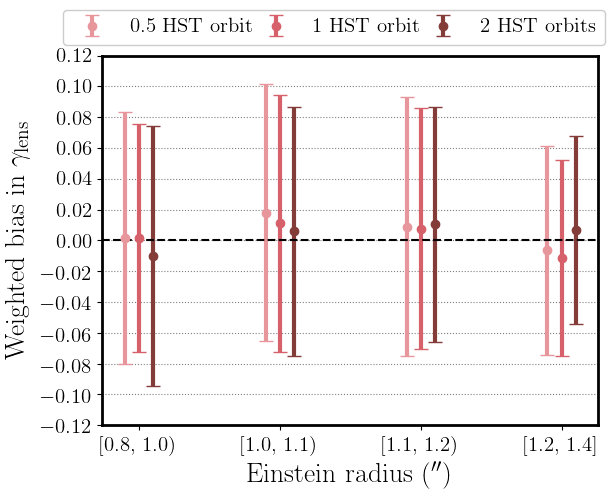

In [79]:
plt.close('all')
param_name = 'lens_mass_gamma'
param_label = '$\gamma_{\mathrm{lens}}$'

for orbit_i, orbit in enumerate(orbits_available):
    version_info = get_version_info(orbit_to_ver[orbit])
    # Bias = predicted - truth
    version_info['summary_pred']['{:s}_bias'.format(param_name)] = version_info['pred_mean'][param_name] - version_info['summary_pred'][param_name]
    handpicked_metric = version_info['summary_pred']['lens_mass_theta_E'].values
    handpicked_metric_bins = np.quantile(handpicked_metric, [0.25, 0.5, 0.75, 1])
    handpicked_metric_bins[-1] += 1.e-7 # buffer 
    version_info['summary_pred']['handpicked_metric_bins'] = np.digitize(handpicked_metric, handpicked_metric_bins)
    print(handpicked_metric_bins, np.min(handpicked_metric))
    centers = []
    yerr_lower = []
    yerr_upper = []
    pm = [] # plus minus (error bars)
    for bin_i in range(4): # smallest separation is bin 0
        binned_pred = version_info['summary_pred'][version_info['summary_pred']['handpicked_metric_bins']==bin_i]
        binned_std = version_info['pred_std'][version_info['summary_pred']['handpicked_metric_bins']==bin_i]
        center = np.average(binned_pred['{:s}_bias'.format(param_name)].values, weights=1.0/binned_std[param_name].values**2.0)
        weighted_std = np.average((binned_pred['{:s}_bias'.format(param_name)].values - center)**2.0, weights=1.0/binned_std[param_name].values**2.0)**0.5
        #print(center, weighted_std)
        centers.append(center)
        pm.append(weighted_std)
        yerr_lower.append(center - weighted_std)
        yerr_upper.append(center + weighted_std)
    orbit_label = '{:s} HST orbit'.format(str(orbit)) if orbit < 2 else '{:s} HST orbits'.format(str(orbit))
    plt.errorbar(np.array([0, 1, 2, 3]) + orbit_i*0.1 - 0.2, centers, yerr=pm, fmt='o', color=orbit_to_color[orbit], alpha=1.0, lw=3, capsize=5, label=orbit_label)

#labels = ['Smaller separation', 'Bigger separation']
#plt.xticks([0.2, 2.6], labels=labels, fontsize=15)

labels = ['[0.8, 1.0)', '[1.0, 1.1)', '[1.1, 1.2)', '[1.2, 1.4]']
plt.xticks(np.arange(4) - 0.1, labels=labels, fontsize=15)

plt.xlabel(r"Einstein radius ($''$)", fontsize=20)
#plt.xlim([-0.5, 3.5])

plt.axhline(0, c='k', linestyle='--')
plt.yticks(np.linspace(-0.12, 0.12, 13), fontsize=15)
plt.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')

#plt.minorticks_on()
plt.ylabel('Weighted bias in {:s}'.format(param_label), fontsize=20)
plt.legend(loc='lower left', framealpha=1.0, bbox_to_anchor=(-0.1, 1), ncol=3, columnspacing=0.075, fontsize=15)
plt.savefig('../gamma_theta_E.png', bbox_inches='tight', pad_inches=0) #dpi=1200)
plt.show()